In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pylab as pl
import seaborn as sns
sns.set_style('whitegrid')

# UDPNY 2018 - _phase #3_
# _new edition according to udp methodology and revision - September '18_

This code defines the _**8 displacement typologies**_ and assignes each tract to a typology. 

- [UDP's methodology / displacement typollogies](https://drive.google.com/file/d/1nwOoVItI5RLLILrFpbTRoXbrjIohnSPY/view)

----
# UDP Gentrification and Displacement Typologies
The typologies (**Updated to October 2018**) can be found in the udp website under _[Gentrification and Displacement Census Tract Typologies](https://drive.google.com/file/d/1nwOoVItI5RLLILrFpbTRoXbrjIohnSPY/view])_
### _8 Typologies_ to be generated to the displacement map:

### Low Income:
1. LI - Not Losing Low-Income Households
2. LI - At Risk of Gentrification
3. LI - Ongoing Displacement of Low-Income Households
4. LI - Ongoing Gentrification 

### Moderate to High Income:
5. MHI - Advanced Gentrification
6. MHI - Not Losing Low-Income Households
7. MHI - At Risk of Exclusion
8. MHI - Displacement of Low-Income Households - Ongoing Exclusion 

---
# 1. Data 
- This notebook uses the data was given by the Berkeley UDP team for the New-York region;
- For the data aquisition process, including logistic regressions for the variables please refer to https://github.com/geeroovaa/udp

In [25]:
data = pd.read_stata("data/UDP_NYC_Variables.dta")
print(data.shape)

(5338, 89)


In [26]:
list(data.columns)

['GEOid2',
 'hh16',
 'moe_hh16',
 'per_col00',
 'per_nonwhite00',
 'per_rent00',
 'vli2000',
 'li2000',
 'mi2000',
 'hmi2000',
 'hi2000',
 'vhi2000',
 'per_all_li00',
 'hh00',
 'all_li_count00',
 'per_nonwhite90',
 'per_rent90',
 'vli1990',
 'li1990',
 'mi1990',
 'hmi1990',
 'hi1990',
 'vhi1990',
 'denominator',
 'per_all_li90',
 'all_li_count90',
 'pop00',
 'pop16',
 'moe_pop16',
 'ch_all_li_count90_00',
 'ch_all_li_count00_16',
 'moveinincd16',
 'co_med_indinc16',
 'per_limove16',
 'per_limove09',
 'TOD',
 'empd15',
 'mrent90',
 'rou90',
 'mrent00',
 'rou00',
 'mrent16',
 'moe_mrent16',
 'mhval90',
 'ohu90',
 'mhval00',
 'ohu00',
 'mhval16',
 'moe_mhval16',
 'mhval90_00',
 'mhval00_16',
 'mrent90_00',
 'mrent00_16',
 'hu16',
 'per_units_pre50',
 'ohu16',
 'moe_owner16',
 'rhu16',
 'moe_renter16',
 'per_rent16',
 'per_nonwhite16',
 'vli2016',
 'li2016',
 'mi2016',
 'hmi2016',
 'hi2016',
 'vhi2016',
 'per_all_li16',
 'all_li_count16',
 'ag25up',
 'bachelors',
 'moe_bachelors',
 'master

## 1.1 Data cleaning and munging
- Dropping tracts with _**population less than 500**_ (2016)
- Dropping tracts with _**more than 5 'Null' columns**_
- calculating coefficient of variation according to MOE (drop **_> 30% of variation_**)
- reading in tracts' shapefile in order to claculate _**pop densities**_

In [27]:
print("# of tracts in data before cleaning: ", data.shape[0])

# Dropping tracts with population less than 500 (2016)
data = data[data['pop16'] > 500]
# Dropping tracts with more than 5 'Null' columns
data = data[data.isnull().sum(axis=1) <= 5]

print("# of tracts in data after cleaning: ", data.shape[0])

# of tracts in data before cleaning:  5338
# of tracts in data after cleaning:  5192


### Coefficient of variation of MOE
## _Tracts with a coefficient of variation > 30% on several key 2016 variables are flagged and determined unreliable:_
- Population -- V
- Housing units -- V
- Median rent -- V
- Median home value -- V
- Median income  -- **_no MOE in the data_**
- College count
- Renter count -- V

In [28]:
# Population
data = data[(data.moe_pop16 / 1.645 ) / data.pop16 <= 0.3]
# Housing Units
data = data[(data.moe_hu16 / 1.645 ) / data.hu16 <= 0.3]
# Bachelors count
data = data[(data.moe_bachelors / 1.645 ) / data.bachelors <= 0.3]

# Renter counts, Median rent, Median home value
# dividing data to ct with majority of renters vs homeowners
datarent = data[data.per_rent16 > 0.5]
dataowner = data[data.per_rent16 <= 0.5]

# Renter count, ownership counts
datarent = datarent[(datarent.moe_renter16 / 1.645)  / datarent.rhu16 <= 0.3]
dataowner = dataowner[(dataowner.moe_owner16 / 1.645 ) / dataowner.ohu16 <= 0.3]

# Median rent, Median home value
datarent = datarent[(datarent.moe_mrent16 / 1.645)  / datarent.mrent16 <= 0.3]
dataowner = dataowner[(dataowner.moe_mhval16 / 1.645 ) / dataowner.mhval16 <= 0.3]

# concatenating two datasets back to 'data'
data = [dataowner, datarent]
data = pd.concat(data)
data.shape

(4758, 89)

In [29]:
(5192-data.shape[0]) / 5192

0.08359013867488443

#### _4,758 CT were found valid for the analysis -- 8.3% were dropped._

### Census tracts shapefiles + calculating population densities

In [30]:
data.iloc[:5,:1]

,GEOid2
0,09001010101
3,09001010202
5,09001010400
9,09001010800
10,09001010900


In [31]:
Alltracts = gpd.GeoDataFrame.from_file("data/MM_Tracts_CSA-NYMetro/MM_Tracts_CSA-NYMetro.shp")
Alltracts = Alltracts[Alltracts['CSA'] == '408'].reset_index()
Alltracts = Alltracts[['GEOID', 'ALAND_mi', 'geometry']]

print(Alltracts.shape)
Alltracts.head()

(5297, 3)


,GEOID,ALAND_mi,geometry
0,34003003200,0.47916,"POLYGON ((-74.000221 40.914034, -73.9994909999..."
1,34003003402,0.40644,"POLYGON ((-74.01045499999999 40.914168, -74.00..."
2,34003004002,0.42869,"POLYGON ((-74.03627399999999 40.879097, -74.03..."
3,34003015500,1.43050,"POLYGON ((-73.984858 40.87487, -73.98401799999..."
4,34003023401,0.16760,"POLYGON ((-74.06457 40.887063, -74.062236 40.8..."


In [32]:
data_shp = Alltracts.merge(data, left_on='GEOID', right_on='GEOid2').drop('GEOid2', axis=1)\
                                                                        .set_index('GEOID')

# calculate pop density at 2016
data_shp['pop_density16'] = data_shp['pop16'] / data_shp['ALAND_mi']

# replicating data_shp to data
data = data_shp.drop(['ALAND_mi'], axis=1)

print(type(data_shp))
print(type(data))
print(data.shape)
data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
(4758, 90)


,geometry,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16,pop_density16
GEOID,,,,,,,,,,,,,,,,,,,,,
34003003200,"POLYGON ((-74.000221 40.914034, -73.9994909999...",1818.0,75.0,0.247377,0.476583,0.536743,0.318922,0.219438,0.118793,0.093017,...,0.179408,71.0,69531.0,13744.0,560.0,67178.500000,66941.400411,0.003542,0.035019,10526.755155
34003003402,"POLYGON ((-74.01045499999999 40.914168, -74.00...",1028.0,52.0,0.432369,0.416820,0.118849,0.170313,0.198515,0.125508,0.106981,...,0.287577,45.0,105776.0,13007.0,569.0,97150.000000,96268.984734,0.009152,0.088791,9415.903946
34003004002,"POLYGON ((-74.03627399999999 40.879097, -74.03...",1758.0,112.0,0.283652,0.366105,0.331942,0.244617,0.184616,0.113347,0.098640,...,0.136622,102.0,78306.0,4222.0,-21.0,86728.851241,84282.688605,0.029023,-0.097117,11607.455271
34003015500,"POLYGON ((-73.984858 40.87487, -73.98401799999...",2366.0,163.0,0.592240,0.352864,0.323038,0.172292,0.159436,0.084572,0.043188,...,1.542397,132.0,112723.0,8079.0,-239.0,124537.600000,114894.324654,0.083932,-0.094868,4092.275428
34003023401,"POLYGON ((-74.06457 40.887063, -74.062236 40.8...",1714.0,105.0,0.365932,0.519520,0.820426,0.283204,0.213065,0.114194,0.094534,...,0.344021,68.0,71197.0,4529.0,271.0,74602.500000,74190.029896,0.005560,-0.045649,23013.126492


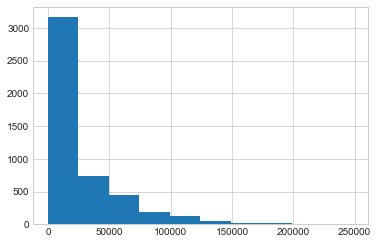

In [33]:
data['pop_density16'].hist()

---
## 1.2 Creating conditional (binary) variables prior classification:

### VLI - Very Low Income tract at 2016 -- _for additional layer on top of typologies_
- vhi2016

In [37]:
# Calculating median for vli and vli % of all hh in tract

median_vli = data['vli2016'].median()
print("the median of very low income households at the year 2016 from total households, "  
      "of all census tracts is: {:.2f}".format(median_vli))

# VLI tract (2016)
data['vli_tract16'] = np.where(data['vli2016'] > 0.5, 1, 0)
print("\nNumber of VLI tracts at 2016: {}".format(data['vli_tract16'].value_counts()[1]))

the median of very low income households at the year 2016 from total households, of all census tracts is: 0.23

Number of VLI tracts at 2016: 194


### Low Income tract
- calculate the median % of all tracts
- Binary output (0 == low income tract; 1 = not a low income tract)

In [38]:
# Calculating median for li and vli % of all hh in tract

medianli = data['vli2016'].median() + data['li2016'].median()
print("the median of low income and very low income households at the year 2016 from total households, "  
      "of all census tracts is: {:.2f}".format(medianli))

# LI 2016
data['li_tract16'] = np.where(data['vli2016']+data['li2016'] > medianli, 1, 0)
print("\nNumber of LI tracts at 2016: {}".format(data['li_tract16'].value_counts()[1]))

# LI 2000
data['li_tract00'] = np.where(data['vli2000']+data['li2000'] > (data['vli2000'].median() + data['li2000'].median()), 1, 0)
print("Number of LI tracts at 2000: {}".format(data['li_tract00'].value_counts()[1]))

# LI 1990
data['li_tract90'] = np.where(data['vli1990']+data['li1990'] > (data['vli1990'].median() + data['li1990'].median()), 1, 0)
print("Number of LI tracts at 1990: {}".format(data['li_tract90'].value_counts()[1]))

the median of low income and very low income households at the year 2016 from total households, of all census tracts is: 0.37

Number of LI tracts at 2016: 2521
Number of LI tracts at 2000: 2491
Number of LI tracts at 1990: 2513


### Ownership / Rentals oriented
Does the tract has more than 50% renters?

In [39]:
data['rentOriented_90'] = np.where(data['per_rent90'] >= 0.5, 1, 0)
data['rentOriented_00'] = np.where(data['per_rent00'] >= 0.5, 1, 0)
data['rentOriented_16'] = np.where(data['per_rent16'] >= 0.5, 1, 0)

print('In 1990, {} tracts were Renters-oriented while {} Ownerships-oriented'.format(
                                            data['rentOriented_90'].value_counts()[1],
                                            data['rentOriented_90'].value_counts()[0]))
print('In 2000, {} tracts were Renters-oriented while {} Ownerships-oriented'.format(
                                            data['rentOriented_00'].value_counts()[1],
                                            data['rentOriented_00'].value_counts()[0]))
print('In 2016, {} tracts were Renters-oriented while {} Ownerships-oriented'.format(
                                            data['rentOriented_16'].value_counts()[1],
                                            data['rentOriented_16'].value_counts()[0]))

In 1990, 1854 tracts were Renters-oriented while 2904 Ownerships-oriented
In 2000, 1993 tracts were Renters-oriented while 2765 Ownerships-oriented
In 2016, 1966 tracts were Renters-oriented while 2792 Ownerships-oriented


### % renters > regional median

In [40]:
data['renters%90'] = np.where(data['per_rent90'] > data['per_rent90'].median(), 1, 0)
data['renters%00'] = np.where(data['per_rent00'] > data['per_rent00'].median(), 1, 0)
data['renters%16'] = np.where(data['per_rent16'] > data['per_rent16'].median(), 1, 0)

### % college educated < regional median 

In [41]:
data['edulow90'] = np.where(data['per_col90'] < data['per_col90'].median(), 1, 0)
data['edulow00'] = np.where(data['per_col00'] < data['per_col00'].median(), 1, 0)

### % nonwhite > regional median

In [42]:
data['nonwhiteHigh90'] = np.where(data['per_nonwhite90'] > data['per_nonwhite90'].median(), 1, 0)
data['nonwhiteHigh00'] = np.where(data['per_nonwhite00'] > data['per_nonwhite00'].median(), 1, 0)
data['nonwhiteHigh16'] = np.where(data['per_nonwhite16'] > data['per_nonwhite16'].median(), 1, 0)

### % of units in pre-1950 buildings > regional median

In [43]:
data['units_pre50_High'] = np.where(data['per_units_pre50'] > data['per_units_pre50'].median(), 1, 0)

### Employment density (2015) > regional median

In [44]:
data['empdens16_High'] = np.where(data['empd15'] > data['empd15'].median(), 1, 0)

### Population stable / growing 1990-2000; 2000-2016
first step: recalculating **population growth in 90-00; 00-16**

In [45]:
# recalculating popgrowth 90-00; 00-16
data['popgrowth90-00'] = data['pop00'] - data['pop90']
data['popgrowth00-16'] = data['pop16'] - data['pop00']

# Stable / Growing
data['pgrowth90-00_High'] = np.where(data['popgrowth90-00'] >= 0, 1, 0)
data['pgrowth00-16_High'] = np.where(data['popgrowth00-16'] >= 0, 1, 0)

### Population Density < regional median

In [46]:
data['popDensLow16'] = np.where(data['pop_density16'] < data['pop_density16'].median(), 1, 0)

### Loss of LI households 1990-2000; 2000-2016 (_absolute loss_)
- ch_all_li_count90_00 < 0
- ch_all_li_count00_16 < 0

In [47]:
data['lossLI90-00'] = np.where(data['ch_all_li_count90_00'] < 0, 1, 0)
data['lossLI00-16'] = np.where(data['ch_all_li_count00_16'] < 0, 1, 0)

### LI migration rate in 2015 < in 2009

per_limove09 > per_limove16

In [48]:
data['moveinLI_decrease00'] = np.where(data['per_limove16'] < data['per_limove09'], 1, 0)

### Define Educated growth > region median
1. Calculate change in college educators % 90-00, 00-16

In [49]:
data['edu_change90-00'] = data['per_col00'] - data['per_col90']
data['edu_change00-16'] = data['per_col_16'] - data['per_col00']

data['edugrowth_High90'] = np.where(data['edu_change90-00'] > data['edu_change90-00'].median(), 1, 0)
data['edugrowth_High00'] = np.where(data['edu_change00-16'] > data['edu_change00-16'].median(), 1, 0)

### % of households w children for 90,00,16 < regional median

In [ ]:
data['lessChildren90'] = np.where(data['per_hhwchild_90'] < data['per_hhwchild_90'].median(), 1, 0)
data['lessChildren00'] = np.where(data['per_hhwchild_00'] < data['per_hhwchild_00'].median(), 1, 0)
data['lessChildren16'] = np.where(data['per_hhwchild_16'] < data['per_hhwchild_16'].median(), 1, 0)

### Growth in real median household income (% change) > regional median (90 and 00)

In [50]:
data['hhIncomeGrowthHigh90'] = np.where(data['pct_ch_hinc90_00'] > data['pct_ch_hinc90_00'].median(), 1, 0)
data['hhIncomeGrowthHigh00'] = np.where(data['pct_ch_hinc00_16'] > data['pct_ch_hinc00_16'].median(), 1, 0)

### Rent change 90-00; 00-16 and home value change 90-00; 00-16 > regional median

In [51]:
# 1990 base
data['rentchange_High90'] = np.where(data['mrent90_00'] > data['mrent90_00'].median(), 1, 0)
data['rhomeValchange_High90'] = np.where(data['mhval90_00'] > data['mhval90_00'].median(), 1, 0)

# 2000 base
data['rentchange_High00'] = np.where(data['mrent00_16'] > data['mrent00_16'].median(), 1, 0)
data['rhomeValchange_High00'] = np.where(data['mhval00_16'] > data['mhval00_16'].median(), 1, 0)

### Rail station (TOD)

In [52]:
data['TOD'].value_counts()

0.0    4012
1.0     746
Name: TOD, dtype: int64

### New built housing > regional median

In [ ]:
data['newBuilt_90'] = np.where(data['per_units_post80'] > data['per_units_post80'].median(), 1, 0)
data['newBuilt_00'] = np.where(data['per_units_post90'] > data['per_units_post90'].median(), 1, 0)
data['newBuilt_16'] = np.where(data['per_units_post00'] > data['per_units_post00'].median(), 1, 0)

### Demographic change 90-00, 00-16 (2 out of 3 factors)

In [53]:
# Demographic change 90-00
def Dchange90(df):
    if df['edugrowth_High90'] == 1 and df['hhIncomeGrowthHigh90'] == 1:
        val = 1
    elif df['edugrowth_High90'] == 1 and df['lossLI90-00'] == 1:
        val = 1
    elif df['hhIncomeGrowthHigh90'] == 1 and df['lossLI90-00'] == 1:
        val = 1
    else:
        val = 0
    return val

# Demographic change 00-16
def Dchange00(df):
    if df['edugrowth_High00'] == 1 and df['hhIncomeGrowthHigh00'] == 1:
        val = 1
    elif df['edugrowth_High00'] == 1 and df['lossLI00-16'] == 1:
        val = 1
    elif df['hhIncomeGrowthHigh00'] == 1 and df['lossLI00-16'] == 1:
        val = 1
    else:
        val = 0
    return val


data['Dchange90'] = data.apply(Dchange90, axis=1)
data['Dchange00'] = data.apply(Dchange00, axis=1)

## 1.2 Define "Hot Market"
- Change in median real rent &gt; regional median<br>
**or**<br>
- Change in median value for owner-occupied homes &gt; regional median

In [54]:
def hotmarket90(df):
    if df['rentOriented_90'] == 1 and df['rentchange_High90'] == 1:
        val = 1
    elif df['rentOriented_90'] == 0 and df['rhomeValchange_High90'] == 1:
        val = 1
    else:
        val = 0
    return val

def hotmarket00(df):
    if df['rentOriented_00'] == 1 and df['rentchange_High00'] == 1:
        val = 1
    elif df['rentOriented_00'] == 0 and df['rhomeValchange_High00'] == 1:
        val = 1
    else:
        val = 0
    return val

data['hotmarket90'] = data.apply(hotmarket90, axis=1)
data['hotmarket00'] = data.apply(hotmarket00, axis=1)

print("In 1990, {:.2f} of the tracts in the data were defined as 'Hot Market'".format(
                                            data['hotmarket90'].value_counts([1])[1]))
print("In 2000, {:.2f} of the tracts in the data were defined as 'Hot Market'".format(
                                            data['hotmarket00'].value_counts([1])[1]))

In 1990, 0.55 of the tracts in the data were defined as 'Hot Market'
In 2000, 0.51 of the tracts in the data were defined as 'Hot Market'


--- 

## 1.3 Define _Vulnerable to gentrification_ in 1990 or 2000

- Housing affordable in base year (_Tract not a “Hot market”_) and (**any 2 of 4**):
    - % low income households &gt; regional median
    - % college educated &lt; regional median
    - % renters &gt; regional median
    - % nonwhite &gt; regional median

In [55]:
def vulnerable90(df):
    if df['hotmarket90'] == 0 and df['li_tract90'] == 1 and df['edulow90'] == 1:
        val = 1
    elif df['hotmarket90'] == 0 and df['li_tract90'] == 1 and df['renters%90'] == 1:
        val = 1
    elif df['hotmarket90'] == 0 and df['li_tract90'] == 1 and df['nonwhiteHigh90'] == 1:
        val = 1
    elif df['hotmarket90'] == 0 and df['edulow90'] == 1 and df['renters%90'] == 1:
        val = 1
    elif df['hotmarket90'] == 0 and df['edulow90'] == 1 and df['nonwhiteHigh90'] == 1:
        val = 1
    elif df['hotmarket90'] == 0 and df['renters%90'] == 1 and df['nonwhiteHigh90'] == 1:
        val = 1
    else:
        val = 0
    return val

def vulnerable00(df):
    if df['hotmarket00'] == 0 and df['li_tract00'] == 1 and df['edulow00'] == 1:
        val = 1
    elif df['hotmarket00'] == 0 and df['li_tract00'] == 1 and df['renters%00'] == 1:
        val = 1
    elif df['hotmarket00'] == 0 and df['li_tract00'] == 1 and df['nonwhiteHigh00'] == 1:
        val = 1
    elif df['hotmarket00'] == 0 and df['edulow00'] == 1 and df['renters%00'] == 1:
        val = 1
    elif df['hotmarket00'] == 0 and df['edulow00'] == 1 and df['nonwhiteHigh00'] == 1:
        val = 1
    elif df['hotmarket00'] == 0 and df['renters%00'] == 1 and df['nonwhiteHigh00'] == 1:
        val = 1
    else:
        val = 0
    return val


data['vulnerable90'] = data.apply(vulnerable90, axis=1)
data['vulnerable00'] = data.apply(vulnerable00, axis=1)

print("In 1990, {:.2f} of the tracts were defined as 'Vulnerable'".format(
                                data['vulnerable90'].value_counts([1])[1]))
print("In 2000, {:.2f} of the tracts were defined as 'Vulnerable'".format(
                                data['vulnerable00'].value_counts([1])[1]))

In 1990, 0.25 of the tracts were defined as 'Vulnerable'
In 2000, 0.24 of the tracts were defined as 'Vulnerable'


---
## 1.4 Define risk of gentrification
4 out of the 8 of the following is true in 2016:
- Located downtown
- % of units in pre-1950 buildings > regional median
- Share of renter households > regional median
- Share of households with children < regional median
- Share of recent new-build housing > regional median
- Employment density < regional median
- Population density < regional median
- “Hot market”

In [ ]:
def risk16(df):
    if df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1:
        val = 1
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['newBuilt_16'] == 1:
        val = 1
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['empdens16_High'] == 1:
        val = 1   
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['popDensLow16'] == 1:
        val = 1     
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['hotmarket00'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['empdens16_High'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['popDensLow16'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['hotmarket00'] == 1:
        val = 1    
    elif df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['empdens16_High'] == 1:
        val = 1
    elif df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['popDensLow16'] == 1:
        val = 1
    elif df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['hotmarket00'] == 1:
        val = 1
    elif df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['empdens16_High'] == 1 and df['popDensLow16'] == 1:
        val=1
    elif df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['empdens16_High'] == 1 and df['hotmarket00'] == 1:
        val=1
    elif df['newBuilt_16'] == 1 and df['empdens16_High'] == 1 and df['popDensLow16'] == 1 and df['hotmarket00'] == 1:
        val=1
    else:
        val = 0
    return val

data['risk16'] = data.apply(risk16, axis=1)

## 1.5 Gentrified 90 + Gentrified 00

In [68]:
data['Gentrified90'] = np.where((data['Volnurable90'] == 1) & (data['Dchange90'] == 1) &
                                (data['hotmarket90'] == 1), 1, 0)
data['Gentrified00'] = np.where((data['Volnurable00'] == 1) & (data['Dchange00'] == 1) &
                                (data['hotmarket00'] == 1) & (data['moveinLI_decrease00'] == 1), 1, 0)

data.iloc[10:16,-3:]

,Dchange00,Gentrified90,Gentrified00
19,0,0,0
20,1,0,0
21,1,0,0
22,1,0,0
23,0,0,0
24,0,0,0


---

# 2. Classify census tracts by typologies


## _MHI - Advanced / Completed Gentrification_
    - Pop in 2000>500
    - Moderate to High Income Tract in 2015
    - Gentrified in in 1990-2000 or 2000-2015 (Defined in Appendix)

In [71]:
# Advanced Gentrification (Moderate to High Income)

def AdvancedGen(df):
    if df['li_tract16'] == 0 and df['Gentrified90'] == 1 and df['VLI'] == 0:
        val = 1
    elif df['li_tract16'] == 0 and df['Gentrified00'] == 1 and df['VLI'] == 0:
        val = 1
    else:
        val = 0
    return val

In [72]:
data['AdvancedGen'] = data.apply(AdvancedGen, axis=1)
data['AdvancedGen'].value_counts()

0    4529
1     229
Name: AdvancedGen, dtype: int64

# _4. LI - Ongoing Gentrification_

    - Pop in 2000 > 500
    - Low Income Tract in 2016
    - Vulnerable in 2000 (Defined in Appendix)
    - Population stable or growing 2000-2016
    - Loss of LI households 2000-2016 (absolute loss)
    - Either:
        o “Hot market” (Defined in Appendix)
        o LI migration rate (percent of all migration to tract that was LI)
    in 2016 < in 2009
    - Gentrified in 1990-2000 or 2000-2016 (Defined in Appendix)

In [73]:
# Displacement of LowIncome Households/Ongoing Gentrification (Low Income)

def OngoingGenLI(df):
    # gentrified in 90, LI tract in 2015
    if df['li_tract16'] == 1 and df['Gentrified90'] == 1 and df['AdvancedGen'] == 0:
        val = 1
    # gentrified in 00, LI tract in 2015
    elif df['li_tract16'] == 1 and df['Gentrified00'] == 1 and df['AdvancedGen'] == 0:
        val = 1
    # LI tract in 2016; Vulnerable in 2000; pop growth; Loss of LI households; hot market in 90
    elif df['li_tract16'] == 1 and df['Volnurable00'] == 1 and df['popgrowth00-16'] == 1\
        and df['lossLI00-16'] == 1  and df['hotmarket90'] == 1 and df['AdvancedGen'] == 0:
        val = 1
    # LI tract in 2016; Vulnerable in 2000; pop growth; Loss of LI households; hot market in 00
    elif df['li_tract16'] == 1 and df['Volnurable00'] == 1 and df['popgrowth00-16'] == 1\
        and df['lossLI00-16'] == 1 and df['hotmarket00'] == 1 and df['AdvancedGen'] == 0:
        val = 1
    #     # LI tract in 2016; Vulnerable in 2000; pop growth; Loss of LI households; LI migration rate
    elif df['li_tract16'] == 1 and df['Volnurable00'] == 1 and df['popgrowth00-16'] == 1\
        and df['lossLI00-16'] == 1 and df['moveinLI_decrease00'] == 1 and df['AdvancedGen'] == 0:
        val = 1
    else:
        val = 0
    return val

In [74]:
data['OngoingGenLI'] = data.apply(OngoingGenLI, axis=1)
data['OngoingGenLI'].value_counts()

0    4256
1     502
Name: OngoingGenLI, dtype: int64

# _LI - At Risk of Gentrification _
- Volnurable in 2000 (3 out of 4 variables)
- Not currently undergoing displacement or ongoing gentrification
- 2 out of the 4 of the following is true in 2015( select only one 'hot market' from the 2 'hot market' option)
- Not currently undergoing displacement or ongoing gentrification

In [75]:
data['AtRiskGen'] = np.where((data['li_tract16'] == 1) & (data['Volnurable00'] == 1) &
                            (data['risk00'] == 1) & (data['OngoingGenLI'] == 0), 1, 0)

data['AtRiskGen'].value_counts()

0    4353
1     405
Name: AtRiskGen, dtype: int64

# 2. _LI - Stable (Not losing LI hh)_
   -  _'pop00'_ (>500)
   - Low Income tract in 2015
   - Not classified as At Risk of, Ongoing, or Advanced Gentrification

In [76]:
data['NotloseLI'] = np.where((data['li_tract16'] == 1) & (data['AtRiskGen'] == 0) &
                             (data['OngoingGenLI'] == 0) & (data['AdvancedGen'] == 0), 1, 0)

data['NotloseLI'].value_counts()

0    3144
1    1614
Name: NotloseLI, dtype: int64

---

# _8. MHI - Exclusion_
    - Pop in 2000 > 500
    - Moderate to High Income Tract in 2015
    - <20% LI in 2000 
    - % LI in 2016 < % LI in 2000
    - LI migration < regional median in 2015

In [77]:
data['LI<20%'] = np.where(data['li2016']+data['vli2016'] < 0.2, 1, 0)
data['%LIdecrease'] = np.where(data['li2016'] < data['li2000'], 1, 0)
data['migLI_low'] = np.where(data['per_limove16'] < data['per_limove16'].median(), 1, 0)

data.iloc[:,-3:].head(4)

,LI<20%,%LIdecrease,migLI_low
0,0,0,0
3,1,1,1
5,0,1,1
9,0,0,1


In [78]:
# Advanced Exclusion

def Exclusion(df):
    if df['li_tract16'] == 0 and df['LI<20%'] == 1 and df['%LIdecrease'] == 1 and df['migLI_low'] == 1:
        val = 1
    else:
        val = 0
    return val

In [79]:
data['Exclusion'] = data.apply(Exclusion, axis=1)
data['Exclusion'].value_counts()

0    4534
1     224
Name: Exclusion, dtype: int64

# _7. MHI - At Risk of Exclusion_

    - Pop in 2000 > 500
    - Moderate to High Income Tract in 2015
    - 2 out of the 4 of the following is true in 2015:
        o Has rail station in tract
        o % of units in prewar buildings (1950) > regional median
        o Employment density> regional median
        o “Hot market” (options defined below table)
    - Not currently undergoing exclusion – none of the below classifications are met

In [80]:
data['AtRiskExc'] = np.where((data['li_tract16'] == 0) & (data['risk00'] == 1) &
                            (data['Exclusion'] == 0), 1, 0)

data['AtRiskExc'].value_counts()

0    4288
1     470
Name: AtRiskExc, dtype: int64

# _6. MHI - Stable (Not Losing Low-Income Households)_
    - Pop in 2000>500
    - Moderate to High Income Tract in 2015
    - Not classified as At Risk of, Ongoing, or Advanced Exclusion

In [81]:
data['NotloseHigh'] = np.where((data['li_tract16'] == 0) & (data['AtRiskExc'] == 0) &
                            (data['Exclusion'] == 0), 1, 0)

data['NotloseHigh'].value_counts()

0    3215
1    1543
Name: NotloseHigh, dtype: int64

#  << TYPOLOGY >>

In [82]:
# Advanced Gentrification (Moderate to High Income)

def Typology(df):
    if df['VLI'] == 1:
        val = 'VLI - Highly Vulnerable for Displacement'
    elif df['AdvancedGen'] == 1:
        val = 'MHI - Advanced Gentrification'
    elif df['Exclusion'] == 1:
        val = 'MHI - Exclusion' 
    elif df['AtRiskExc'] == 1:
        val = 'MHI - At Risk of Exclusion'
    elif df['NotloseHigh'] == 1:
        val = 'MHI - Stable, Not Losing Low Income Households'
    elif df['OngoingGenLI'] == 1:
        val = 'LI - Ongoing Gentrification and/or Displacement'
    elif df['AtRiskGen'] == 1:
        val = 'LI - At Risk of Gentrification and/or Displacement'
    elif df['NotloseLI'] == 1:
        val = 'LI - Stable, Not Losing Low Income Households'
    else:
        val = 0
    return val

In [83]:
data['Typology'] = data.apply(Typology, axis=1)
data['Typology'].value_counts()

LI - Stable, Not Losing Low Income Households         1510
MHI - Stable, Not Losing Low Income Households        1478
LI - Ongoing Gentrification and/or Displacement        459
LI - At Risk of Gentrification and/or Displacement     365
MHI - At Risk of Exclusion                             319
MHI - Advanced Gentrification                          229
MHI - Exclusion                                        211
VLI - Highly Vulnerable for Displacement               187
Name: Typology, dtype: int64

In [84]:
len(pd.DataFrame(data['Typology']))#.value_counts()))

4758

In [85]:
resultsTyp = pd.DataFrame(data['Typology'].value_counts())
resultsTyp.columns = ['tractCounts']
resultsTyp['Typology%'] = resultsTyp['tractCounts'] / resultsTyp['tractCounts'].sum() *100

resultsTyp

,tractCounts,Typology%
"LI - Stable, Not Losing Low Income Households",1510,31.736024
"MHI - Stable, Not Losing Low Income Households",1478,31.063472
LI - Ongoing Gentrification and/or Displacement,459,9.646910
LI - At Risk of Gentrification and/or Displacement,365,7.671290
MHI - At Risk of Exclusion,319,6.704498
MHI - Advanced Gentrification,229,4.812947
MHI - Exclusion,211,4.434636
VLI - Highly Vulnerable for Displacement,187,3.930223


In [86]:
resultsTyp.dtypes

tractCounts      int64
Typology%      float64
dtype: object

In [87]:
data.shape

(4758, 141)

In [88]:
data[['GEOid2', 'Typology']].set_index('GEOid2').reset_index()

,GEOid2,Typology
0,09001010101,"MHI - Stable, Not Losing Low Income Households"
1,09001010202,MHI - Exclusion
2,09001010400,"MHI - Stable, Not Losing Low Income Households"
3,09001010800,MHI - At Risk of Exclusion
4,09001010900,"MHI - Stable, Not Losing Low Income Households"
5,09001011000,"MHI - Stable, Not Losing Low Income Households"
6,09001011100,MHI - Exclusion
7,09001020200,MHI - Exclusion
8,09001020300,MHI - Exclusion
9,09001020400,MHI - Exclusion


In [87]:
data[['GEOid2', 'Typology']].set_index('GEOid2').to_csv('UDPNY_revisedTypologies2.csv')

([<matplotlib.patches.Wedge at 0x1a1fe3a588>,
 [Text(0.597091,0.923841,''),
  Text(-1.08383,0.187913,''),
  Text(-0.491803,-0.983936,''),
  Text(0.0885131,-1.09643,''),
  Text(0.558157,-0.947872,''),
  Text(0.857551,-0.688917,''),
  Text(1.01896,-0.414401,''),
  Text(1.09163,-0.135473,'')])

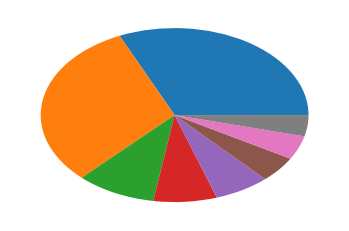

In [91]:
pl.pie(resultsTyp.iloc[:,1])